# Using Pyro for Estimation

<div class="alert alert-info">

Note

Currently we are still experimenting Pyro and support Pyro only with LGT.

</div>

[Pyro](https://github.com/pyro-ppl/pyro)  is a flexible, scalable deep probabilistic programming library built on PyTorch.  **Pyro** was originally developed at Uber AI and is now actively maintained by community contributors, including a dedicated team at the Broad Institute. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models.lgt import LGTAggregated, LGTFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [2]:
print(orbit.__version__)

1.0.15


In [3]:
df = load_iclaims()

In [4]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## VI Fit and Predict

Although Pyro provides a variety of ways to optimize/sample posteriors.  Currently, we only support Stochastic Variational Inference (SVI). For details, please refer to this [doc](https://pyro.ai/examples/svi_part_i.html). To illustrate that, we currently adapt SVI in the `LGTFull` model.

In [5]:
lgt_vi = LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_steps=101,
    num_sample=300,
    message=10,
    learning_rate=0.1,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [6]:
%%time
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 14.7 s, sys: 475 ms, total: 15.1 s
Wall time: 14.8 s


In [7]:
predicted_df = lgt_vi.predict(df=test_df)

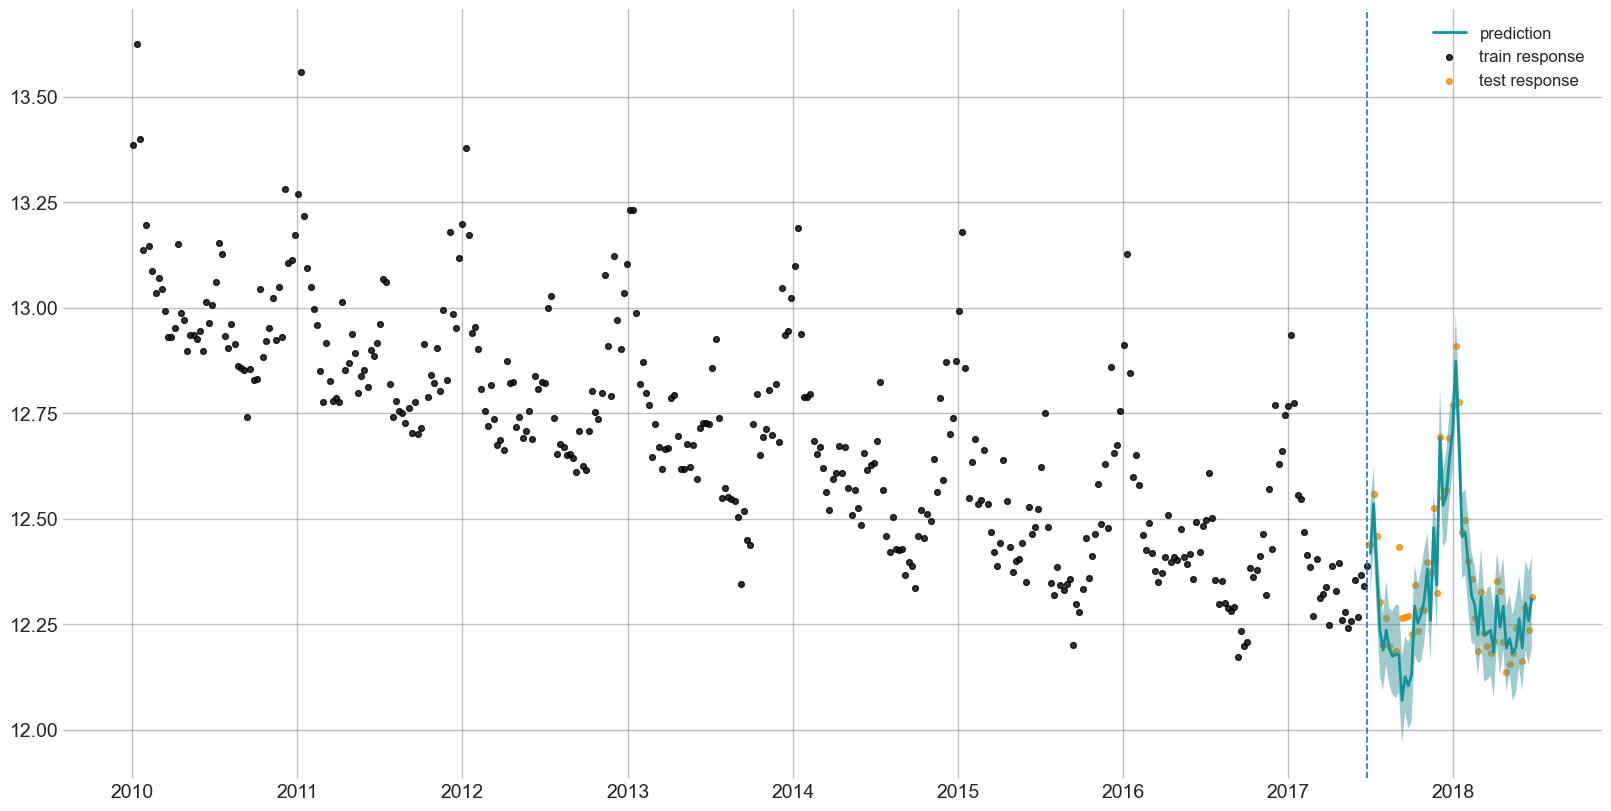

In [8]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, 
                    test_actual_df=test_df)

We can also extract the ELBO loss from the training metrics.

In [9]:
loss_elbo = lgt_vi.get_training_metrics()['loss_elbo']

Text(0.5, 1.0, 'ELBO Loss per Step')

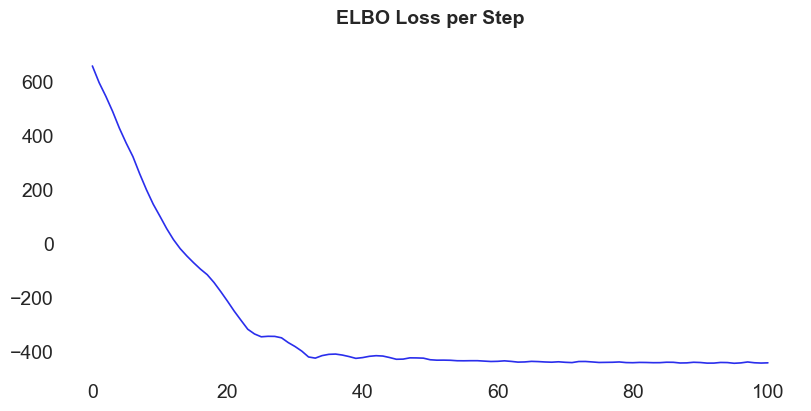

In [12]:
steps = np.arange(len(loss_elbo))
plt.subplots(1, 1, figsize=(8, 4))
plt.plot(steps, loss_elbo)
plt.title('ELBO Loss per Step')